In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import shap

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
    names=[
        'Sample_code_number', 'Clump_Thickness', 'Uniformity_Of_Cell_Size',
        'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single_Epithelial_Cell_Size',
        'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class'
    ]
)

# Remove ID column
df.drop('Sample_code_number', axis=1, inplace=True)

# Convert "?" in 'Bare_Nuclei' to NaN and change dtype to float
df['Bare_Nuclei'] = pd.to_numeric(df['Bare_Nuclei'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Convert target variable (2 -> 0 for benign, 4 -> 1 for malignant)
df['Class'] = df['Class'].map({2: 0, 4: 1}).astype(int)

# Check correlation and remove highly correlated features
correlation_matrix = df.corr()
high_correlation_features = set()
correlation_threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            high_correlation_features.add(colname)

df.drop(columns=high_correlation_features, inplace=True)

# Split data into train-test sets
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(C=0.1),
    "Random Forest": RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)
}

# Train and evaluate models
results = []
fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    # evalution parameters
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)  # see if the prediction of benign is accurate
    recall = recall_score(y_test, y_pred)        # how many benign if captured
    f1 = f1_score(y_test, y_pred)                # balance estimators
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    # 儲存結果
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "AUC": roc_auc
    })

    fpr_dict[name], tpr_dict[name], roc_auc_dict[name] = fpr, tpr, roc_auc

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1-score", ascending=False))  # rank by F1-score



/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 191, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 546, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349817 -> initscore=-0.619844
[LightGBM] [Info] Start training from score -0.619844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

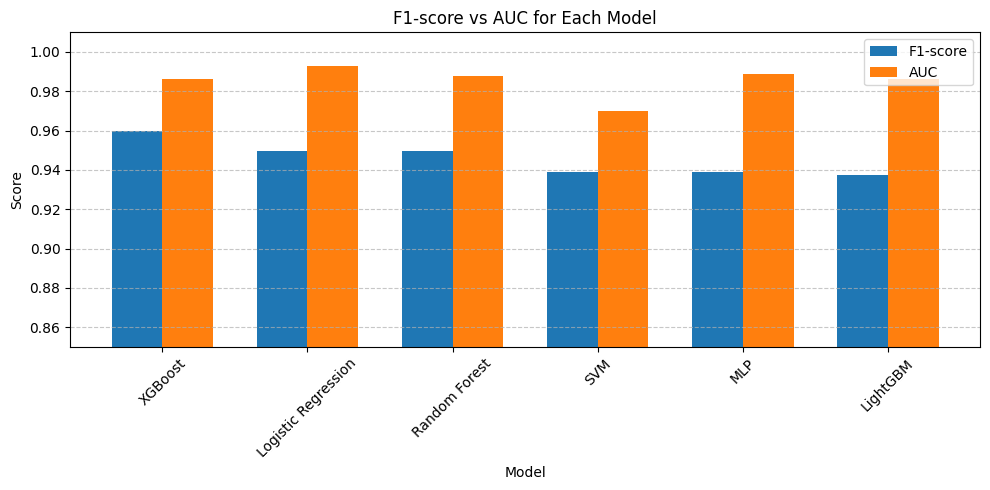

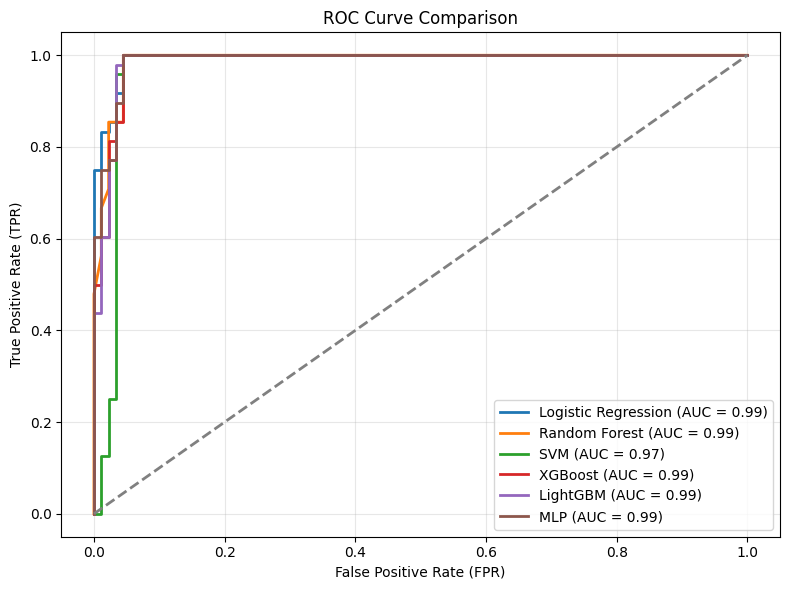


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        89
   Malignant       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137


Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        89
   Malignant       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137


Classification Report for SVM:
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97        89
   Malignant       0.92      0.96      0.94        48

    accuracy                           0.96       137
   mac

In [2]:
# Visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. F1-score vs AUC 
results_df_sorted = results_df.sort_values(by="F1-score", ascending=False)

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(results_df_sorted))

plt.bar(index, results_df_sorted["F1-score"], bar_width, label='F1-score')
plt.bar([i + bar_width for i in index], results_df_sorted["AUC"], bar_width, label='AUC')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('F1-score vs AUC for Each Model')
plt.xticks([i + bar_width / 2 for i in index], results_df_sorted["Model"], rotation=45)
plt.ylim(0.85, 1.01)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. ROC Curve 
plt.figure(figsize=(8, 6))
for name in fpr_dict.keys():
    plt.plot(fpr_dict[name], tpr_dict[name], lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Classification Report 
for name, model in models.items():
    print(f"\nClassification Report for {name}:")
    if name in ["Logistic Regression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

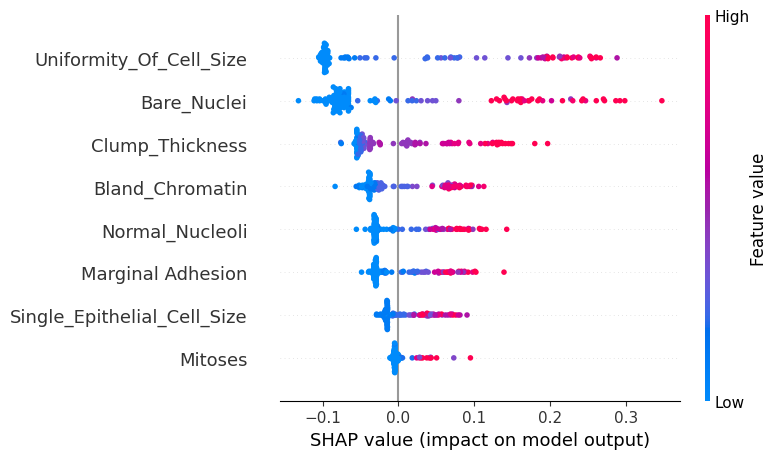

In [3]:
# SHAP Analysis (for Random Forest)
explainer = shap.Explainer(models["Random Forest"], X_train)
shap_values = explainer(X_test)
shap_values_selected = shap_values[:, :, 1]  # SHAP value for category 1 (malignant tumour) only
shap.summary_plot(shap_values_selected, X_test)


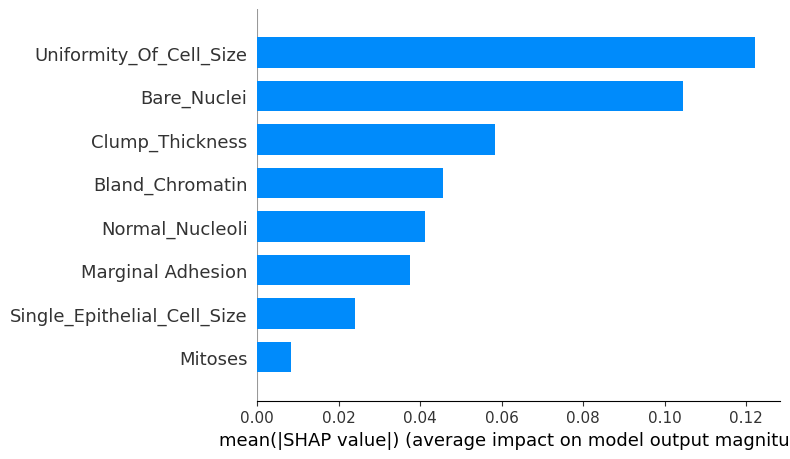

In [4]:
shap.summary_plot(shap_values_selected, X_test, plot_type="bar")


In [5]:
print(type(shap_values_selected))


<class 'shap._explanation.Explanation'>


In [6]:
shap_values_selected = shap_values[:, :, 1].values  # Make sure it's a NumPy array


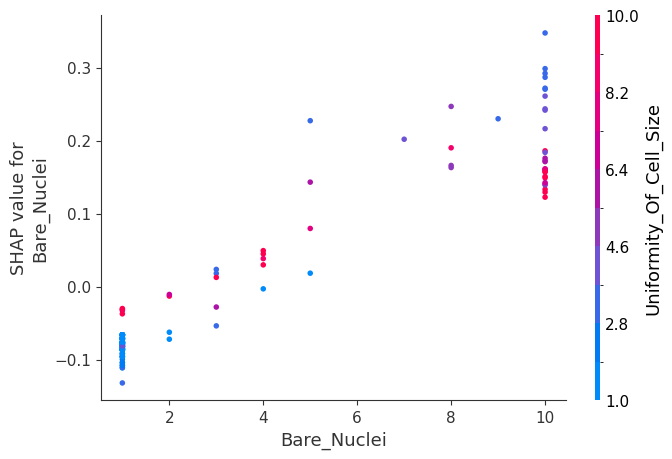

In [7]:
shap.dependence_plot("Bare_Nuclei", shap_values_selected, X_test)

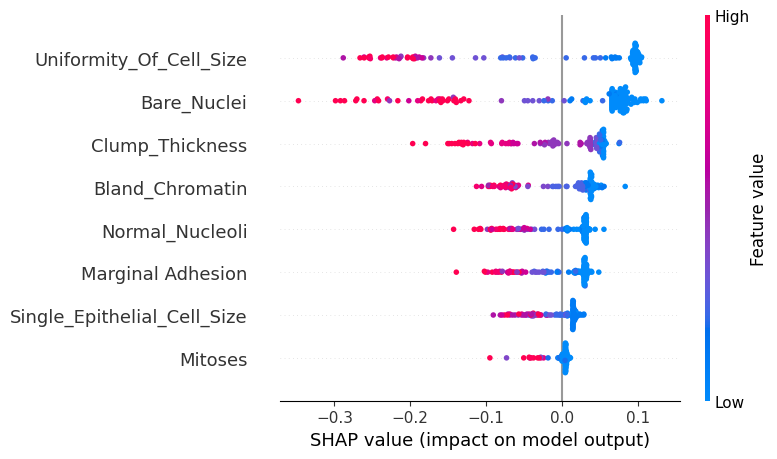

In [8]:
shap_values_selected = shap_values[:, :, 0]  # Benign Tumour
shap.summary_plot(shap_values_selected, X_test)
